In [ ]:
import numpy as np
import pandas as pd
import torch as t
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns

# for reproducibility's sake
np.random.seed(42)
t.manual_seed(42)

In [2]:
print("loading data...")
df_data = pd.read_csv('data/train.csv')

# first few rows
print("data head:")
print(df_data.head())

print("data info:")
print(df_data.info())

print("unique crime categories:", df_data['Category'].nunique())
print(df_data['Category'].value_counts().head(10))

loading data...
data head:
                 Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.4269

In [ ]:
#df_data = df_data.sample(frac=0.8, random_state=42)  # uncomment to use some %frac of it if too much for ur laptop and training takes time hehe

In [3]:
df_data['Dates'] = pd.to_datetime(df_data['Dates'])

df_data['Year'] = df_data['Dates'].dt.year
df_data['Month'] = df_data['Dates'].dt.month
df_data['Day'] = df_data['Dates'].dt.day
df_data['Hour'] = df_data['Dates'].dt.hour
df_data['DayOfYear'] = df_data['Dates'].dt.dayofyear
df_data['WeekOfYear'] = df_data['Dates'].dt.isocalendar().week

# categorical vars
le_day = LabelEncoder()
le_district = LabelEncoder()
df_data['DayOfWeek_enc'] = le_day.fit_transform(df_data['DayOfWeek'])
df_data['PdDistrict_enc'] = le_district.fit_transform(df_data['PdDistrict'])

# encode target var
le_category = LabelEncoder()
df_data['Category_enc'] = le_category.fit_transform(df_data['Category'])
num_classes = df_data['Category_enc'].nunique()
print(f"number of classes: {num_classes}")

number of classes: 39


In [4]:
# select numeric cols for correlation analysis
numeric_cols = ['X', 'Y', 'Year', 'Month', 'Day', 'Hour', 'DayOfYear', 
                'WeekOfYear', 'DayOfWeek_enc', 'PdDistrict_enc', 'Category_enc']
df_numeric = df_data[numeric_cols]

# compute corr matrix with output
corr_matrix = df_numeric.corr()
print("correlation with target:")
print(corr_matrix['Category_enc'].sort_values(ascending=False))

# plot corr heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.close()

correlation with target:
Category_enc      1.000000
Hour              0.023524
Day               0.000805
DayOfWeek_enc     0.000388
DayOfYear         0.000075
Month             0.000008
WeekOfYear       -0.000137
Y                -0.000414
Year             -0.021803
X                -0.024401
PdDistrict_enc   -0.040674
Name: Category_enc, dtype: float64


In [5]:
# select features with corr > 0.2 or based on domain knowledge
# in this case, i did specific location, time, and district
selected_features = ['X', 'Y', 'Hour', 'DayOfYear', 'PdDistrict_enc']
X_np = df_data[selected_features].to_numpy()
y_np = df_data['Category_enc'].to_numpy()

print(f"X shape: {X_np.shape}, y shape: {y_np.shape}")

X shape: (878049, 5), y shape: (878049,)


In [6]:
# split data
X_train, X_val, y_train, y_val = train_test_split(
    X_np, y_np, test_size=0.2, shuffle=True, random_state=42)

# normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"train set: {X_train_scaled.shape}, val set: {X_val_scaled.shape}")

train set: (702439, 5), val set: (175610, 5)


In [7]:
# pytorch tns
X_t_train = t.from_numpy(X_train_scaled).float()
y_t_train = t.from_numpy(y_train).long()
X_t_val = t.from_numpy(X_val_scaled).float()
y_t_val = t.from_numpy(y_val).long()

print(f"X_t_train shape: {X_t_train.shape}, dtype: {X_t_train.dtype}")
print(f"y_t_train shape: {y_t_train.shape}, dtype: {y_t_train.dtype}")

# data loaders
train_data = [(X_t_train[i], y_t_train[i]) for i in range(X_t_train.shape[0])]
trainloader = t.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

val_data = [(X_t_val[i], y_t_val[i]) for i in range(X_t_val.shape[0])]
valloader = t.utils.data.DataLoader(val_data, batch_size=128)

X_t_train shape: torch.Size([702439, 5]), dtype: torch.float32
y_t_train shape: torch.Size([702439]), dtype: torch.int64


In [8]:
# nn
class CrimeClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim, dropout_rate=0.2):
        super(CrimeClassifier, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.layer3(x)  # no activation - will be applied in loss fn
        return x

In [9]:
# train model helper function
def train_model(n_epochs, model, train_loader, val_loader, optimizer, loss_fn, 
              writer, device="cpu"):
    """train nn with given params and log metrics to tensorboard"""
    for epoch in range(n_epochs+1):
        # training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            # zero gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(xb)
            loss = loss_fn(outputs, yb)
            
            # backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # stats
            running_loss += loss.item()
            _, predicted = t.max(outputs.data, 1)
            total += yb.size(0)
            correct += (predicted == yb).sum().item()
        
        # train metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("Accuracy/train", train_acc, epoch)
        
        # eval phase - every 5 epochs
        if epoch % 5 == 0:
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            
            with t.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    
                    outputs = model(xb)
                    loss = loss_fn(outputs, yb)
                    
                    val_loss += loss.item()
                    _, predicted = t.max(outputs.data, 1)
                    val_total += yb.size(0)
                    val_correct += (predicted == yb).sum().item()
            
            # val metrics
            val_loss = val_loss / len(val_loader)
            val_acc = 100 * val_correct / val_total
            
            writer.add_scalar("Loss/val", val_loss, epoch)
            writer.add_scalar("Accuracy/val", val_acc, epoch)
            
            print(f"Epoch {epoch}, Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}%, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%")

In [10]:
# setup device - use gpu if available
# for the rich...
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
print(f"using device: {device}")

# setup logging
writer = SummaryWriter("runs/sf_crime_classifier")

# define models with different architectures for comparison
architectures = [
    {
        "name": "small_model",
        "hidden_dim1": 64,
        "hidden_dim2": 32,
        "lr": 0.001,
        "optimizer": "adam",
        "dropout": 0.2,
        "epochs": 30
    },
    {
        "name": "medium_model",
        "hidden_dim1": 128,
        "hidden_dim2": 64,
        "lr": 0.001,
        "optimizer": "adam",
        "dropout": 0.3,
        "epochs": 30
    },
    {
        "name": "large_model",
        "hidden_dim1": 256,
        "hidden_dim2": 128,
        "lr": 0.0005,
        "optimizer": "adam",
        "dropout": 0.4,
        "epochs": 30
    },
    {
        "name": "sgd_model",
        "hidden_dim1": 128,
        "hidden_dim2": 64,
        "lr": 0.01,
        "optimizer": "sgd",
        "dropout": 0.3,
        "epochs": 30
    }
]

using device: cpu


In [11]:
# train and evaluate each model architecture
results = []
for arch in architectures:
    print(f"\nTraining model: {arch['name']}")
    
    # init model
    model = CrimeClassifier(
        input_dim=X_t_train.shape[1],
        hidden_dim1=arch['hidden_dim1'],
        hidden_dim2=arch['hidden_dim2'],
        output_dim=num_classes,
        dropout_rate=arch['dropout']
    ).to(device)
    
    # setup optimizer
    if arch['optimizer'] == 'adam':
        optimizer = t.optim.Adam(model.parameters(), lr=arch['lr'])
    else:
        optimizer = t.optim.SGD(model.parameters(), lr=arch['lr'], momentum=0.9)
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # train model
    model_writer = SummaryWriter(f"runs/sf_crime_classifier/{arch['name']}")
    train_model(
        n_epochs=arch['epochs'],
        model=model,
        train_loader=trainloader,
        val_loader=valloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        writer=model_writer,
        device=device
    )
    
    # evaluate final model
    model.eval()
    val_correct = 0
    val_total = 0
    
    with t.no_grad():
        for xb, yb in valloader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = t.max(outputs.data, 1)
            val_total += yb.size(0)
            val_correct += (predicted == yb).sum().item()
    
    final_acc = 100 * val_correct / val_total
    print(f"Final validation accuracy for {arch['name']}: {final_acc:.2f}%")
    
    # save results
    results.append({
        "model": arch['name'],
        "hidden_dims": f"{arch['hidden_dim1']}-{arch['hidden_dim2']}",
        "optimizer": arch['optimizer'],
        "learning_rate": arch['lr'],
        "dropout": arch['dropout'],
        "final_accuracy": final_acc
    })
    
    # save model
    t.save(model.state_dict(), f"{arch['name']}_model.pth")
    model_writer.close()


Training model: small_model
Epoch 0, Train loss: 2.6484, Train acc: 21.08%, Val loss: 2.5906, Val acc: 22.68%
Epoch 5, Train loss: 2.5683, Train acc: 23.32%, Val loss: 2.5483, Val acc: 23.88%
Epoch 10, Train loss: 2.5592, Train acc: 23.46%, Val loss: 2.5386, Val acc: 23.93%
Epoch 15, Train loss: 2.5554, Train acc: 23.54%, Val loss: 2.5310, Val acc: 24.08%
Epoch 20, Train loss: 2.5516, Train acc: 23.62%, Val loss: 2.5286, Val acc: 24.22%
Epoch 25, Train loss: 2.5500, Train acc: 23.69%, Val loss: 2.5265, Val acc: 24.23%
Epoch 30, Train loss: 2.5493, Train acc: 23.71%, Val loss: 2.5232, Val acc: 24.44%
Final validation accuracy for small_model: 24.44%

Training model: medium_model
Epoch 0, Train loss: 2.6369, Train acc: 21.46%, Val loss: 2.5829, Val acc: 22.96%
Epoch 5, Train loss: 2.5645, Train acc: 23.34%, Val loss: 2.5398, Val acc: 23.99%
Epoch 10, Train loss: 2.5541, Train acc: 23.57%, Val loss: 2.5291, Val acc: 24.17%
Epoch 15, Train loss: 2.5489, Train acc: 23.68%, Val loss: 2.5227


Model Comparison:
          model hidden_dims optimizer  learning_rate  dropout  final_accuracy
0   small_model       64-32      adam         0.0010      0.2       24.443938
1  medium_model      128-64      adam         0.0010      0.3       24.469563
2   large_model     256-128      adam         0.0005      0.4       24.699618
3     sgd_model      128-64       sgd         0.0100      0.3       23.914356


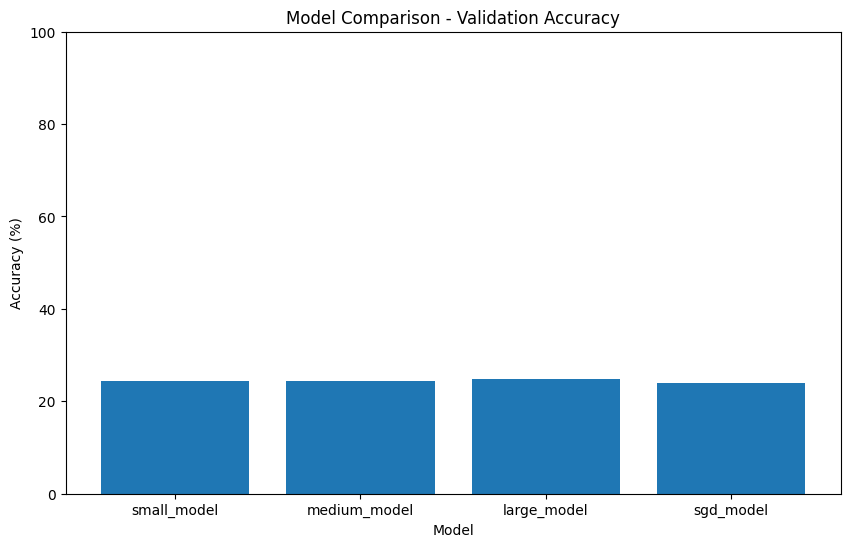

In [12]:
# compare res
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# plot res
plt.figure(figsize=(10, 6))
plt.bar(results_df['model'], results_df['final_accuracy'])
plt.title('Model Comparison - Validation Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.savefig('model_comparison.png')
plt.show()

# close tensorboard writer
writer.close()

In [13]:
# confusion mtx for the best model
# load best model (based on results)
best_model_name = results_df.loc[results_df['final_accuracy'].idxmax(), 'model']
print(f"\nBest model: {best_model_name}")

# recreate best model
best_arch = next(arch for arch in architectures if arch['name'] == best_model_name)
best_model = CrimeClassifier(
    input_dim=X_t_train.shape[1],
    hidden_dim1=best_arch['hidden_dim1'],
    hidden_dim2=best_arch['hidden_dim2'],
    output_dim=num_classes,
    dropout_rate=best_arch['dropout']
).to(device)

# loads saved weights (I added these to .gitignore though)
best_model.load_state_dict(t.load(f"{best_model_name}_model.pth"))
best_model.eval()


Best model: large_model


CrimeClassifier(
  (layer1): Linear(in_features=5, out_features=256, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (layer3): Linear(in_features=128, out_features=39, bias=True)
)

In [14]:
# predict on validation set
all_preds = []
all_labels = []

with t.no_grad():
    for xb, yb in valloader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        _, predicted = t.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Number of unique classes in filtered labels: 15
Number of target names: 15


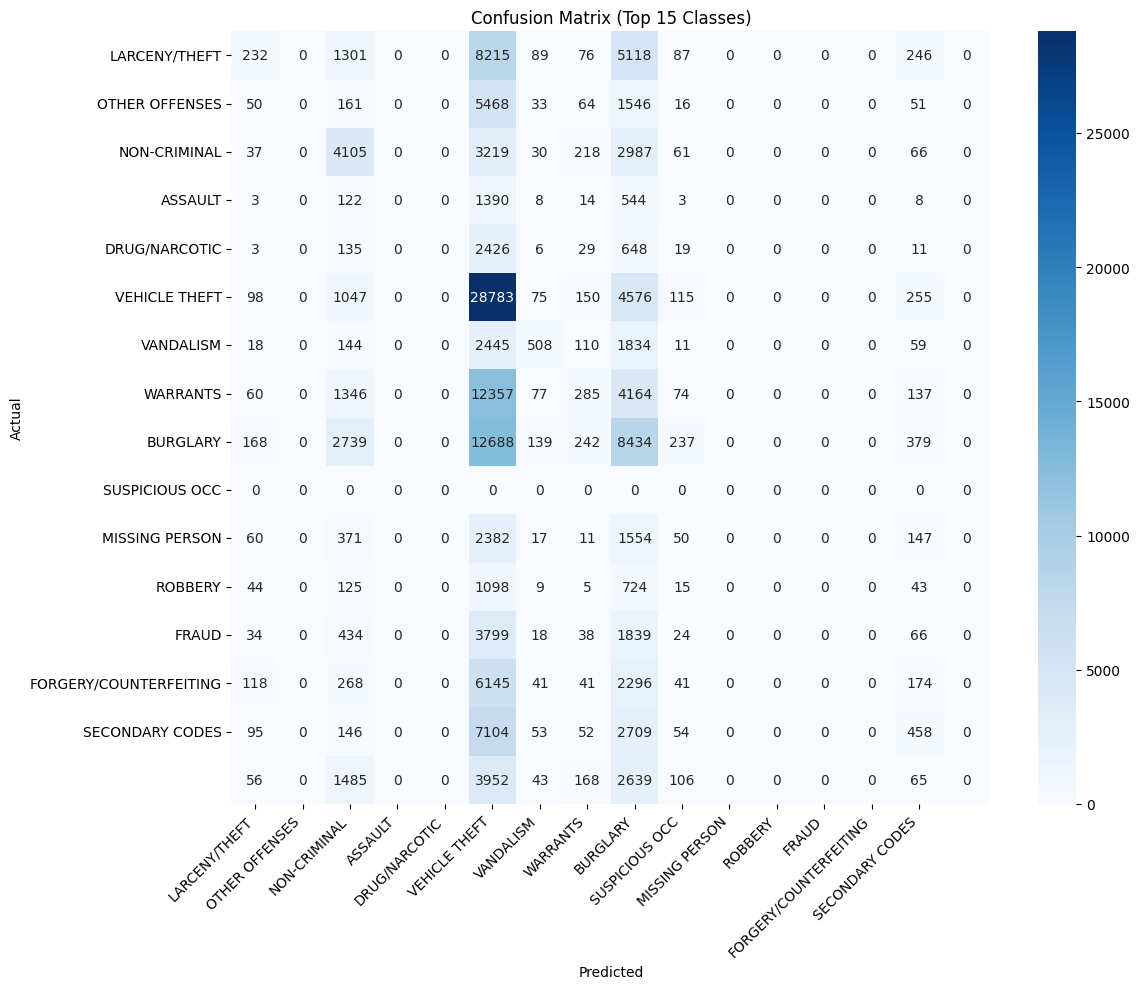


Classification Report (Top 15 Classes):
                        precision    recall  f1-score   support

         LARCENY/THEFT       0.28      0.82      0.42     35099
        OTHER OFFENSES       0.20      0.34      0.25     25026
          NON-CRIMINAL       0.19      0.02      0.03     18500
               ASSAULT       0.22      0.02      0.03     15364
         DRUG/NARCOTIC       0.29      0.38      0.33     10723
         VEHICLE THEFT       0.21      0.04      0.07     10671
             VANDALISM       0.00      0.00      0.00      9124
              WARRANTS       0.00      0.00      0.00      8514
              BURGLARY       0.00      0.00      0.00      7389
        SUSPICIOUS OCC       0.00      0.00      0.00      6252
        MISSING PERSON       0.44      0.10      0.16      5129
               ROBBERY       0.00      0.00      0.00      4592
                 FRAUD       0.00      0.00      0.00      3277
FORGERY/COUNTERFEITING       0.00      0.00      0.00      209

/Users/mani/Desktop/uni/y3/s2/csc158/project-2-project2_team_epmt/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mani/Desktop/uni/y3/s2/csc158/project-2-project2_team_epmt/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mani/Desktop/uni/y3/s2/csc158/project-2-project2_team_epmt/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

top_classes = df_data['Category'].value_counts().nlargest(15).index
top_class_indices = [le_category.transform([cls])[0] for cls in top_classes]

mask_preds = np.isin(all_labels, top_class_indices)
filtered_preds = all_preds[mask_preds]
filtered_labels = all_labels[mask_preds]

unique_classes = np.unique(filtered_labels)
print(f"Number of unique classes in filtered labels: {len(unique_classes)}")
print(f"Number of target names: {len(top_class_indices)}")

# do we only have classes that are in our top classes?
filtered_mask = np.isin(filtered_labels, top_class_indices)
filtered_labels = filtered_labels[filtered_mask]
filtered_preds = filtered_preds[filtered_mask]

# plot confusion matrix
cm = confusion_matrix(filtered_labels, filtered_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=[le_category.inverse_transform([i])[0] for i in top_class_indices],
    yticklabels=[le_category.inverse_transform([i])[0] for i in top_class_indices]
)
plt.title('Confusion Matrix (Top 15 Classes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

print("\nClassification Report (Top 15 Classes):")
target_names = [le_category.inverse_transform([i])[0] for i in top_class_indices]
class_report = classification_report(
    filtered_labels, 
    filtered_preds,
    labels=top_class_indices,  # Explicitly provide the labels
    target_names=target_names
)
print(class_report)

In [17]:
def predict_crime(time, location, district):
    """predict crime category given time and location"""
    # prep input
    hour = time.hour
    day_of_year = time.timetuple().tm_yday
    district_enc = le_district.transform([district])[0]
    
    # create feature array
    features = np.array([[location[0], location[1], hour, day_of_year, district_enc]])
    
    # scale features
    features_scaled = scaler.transform(features)
    
    # convert to tensor
    features_tensor = t.from_numpy(features_scaled).float().to(device)
    
    # get prediction
    best_model.eval()
    with t.no_grad():
        output = best_model(features_tensor)
        _, predicted = t.max(output, 1)
    
    # convert to category name
    category_idx = predicted.item()
    category = le_category.inverse_transform([category_idx])[0]
    
    return category

# test the prediction function
from datetime import datetime
test_time = datetime(2023, 6, 15, 23, 30)  # June 15, 2023, 11:30 PM
test_location = (-122.41, 37.77)  # San Francisco downtown coords
test_district = "SOUTHERN"

predicted_category = predict_crime(test_time, test_location, test_district)
print(f"\nPredicted crime category for test case: {predicted_category}")


Predicted crime category for test case: LARCENY/THEFT
